<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
<h1 align="center" style="margin-top:10px">Machine Learning Using Python (MEAFA Workshop)</h1>
<h2 align="center" style="margin-top:10px">Lesson 4: Logistic Regression and Optimal Decisions</h2>
<br>

The [Lending Club](https://www.lendingclub.com) is a [peer-to-peer lending](https://en.wikipedia.org/wiki/Peer-to-peer_lending) company that provides a platform to match individuals seeking personal loans to investors willing purchase claims on personal loan repayments. 

In this lesson we will apply statistical learning methods to predict the risk of loans in the platform, and to decide whether it is worth it to invest in each of the them based on these predictions.  At the end of the tutorial, we use these tools to build and assess an investment strategy 

<a class="buttom" href=">#Lending-Club-Data">Lending Club Data</a> <br>
<a class="buttom" href=">#Decision-Problem">Decision Problem</a> <br>
<a class="buttom" href="#Exploratory-Data-Analysis">Exploratory Data Analysis</a> <br>
<a class="buttom" href="#Data-Preparation">Feature Engineering and Data Preparation</a> <br>
<a class="buttom" href="#Logistic-Regression">Logistic Regression</a> <br>
<a class="buttom" href="#Model-Evaluation">Model Evaluation</a> <br>
<a class="buttom" href="#Investment-strategy">Investment strategy</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
# Model selection and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, average_precision_score, log_loss

# Data processing
from sklearn.preprocessing import StandardScaler

## Lending Club Data

**Business objective:** to decide whether to invest in specific loans. 

### Data

The Lending Club makes its data openly available on its [loan statistics](https://www.lendingclub.com/info/download-data.action) page. Our analysis is based on the 2007-2011 dataset. The <TT>LoanStats-clean.csv</TT> provides a processed version of the data to save time. )

In [4]:
data = pd.read_csv('Datasets/LoanStats-clean.csv')
data.head()

,funded_amnt,int_rate,installment,annual_inc,dti,revol_bal,revol_util,total_acc,months_since_earliest_cr_line,emp_length,...,term_60,home_ownership_own,home_ownership_rent,verification_status_source verified,verification_status_verified,months_to_last_pymnt,total_pymnt,total_rec_prncp,total_rec_int,fully_paid
0,5000.0,10.65,162.87,24000.0,27.65,13648.0,83.7,9.0,323,10,...,0,0,1,0,1,37,5863.155187,5000.00,863.16,1
1,2500.0,15.27,59.83,30000.0,1.00,1687.0,9.4,4.0,152,0,...,1,0,1,1,0,16,1014.530000,456.46,435.17,0
2,2400.0,15.96,84.33,12252.0,8.72,2956.0,98.5,10.0,121,10,...,0,0,1,0,0,30,3005.666844,2400.00,605.67,1
3,10000.0,13.49,339.31,49200.0,20.00,5598.0,21.0,37.0,190,10,...,0,0,1,1,0,37,12231.890000,10000.00,2214.92,1
4,3000.0,12.69,67.79,80000.0,17.94,27783.0,53.9,38.0,191,1,...,1,0,1,1,0,61,4066.908161,3000.00,1066.91,1


Since the dataset contains many variable, a separate file maps each to column to its type. 

In [5]:
variables = pd.read_csv('Datasets/LoanStats-clean-variables.csv')
variables.head()

,name,type
0,funded_amnt,continuous
1,int_rate,continuous
2,installment,continuous
3,annual_inc,continuous
4,dti,continuous


In [6]:
variables['type'].value_counts()

continuous     9
discrete       6
outcome        5
dummy          5
response       1
categorical    1
Name: type, dtype: int64

In [7]:
response = variables.loc[variables['type'] == 'response', 'name'].values[0]
outcomes = list(variables.loc[variables['type'] == 'outcome', 'name'])
continuous =  list(variables.loc[variables['type'] == 'continuous', 'name'])
discrete = list(variables.loc[variables['type'] == 'discrete', 'name'])
dummies = list(variables.loc[variables['type'] == 'dummy', 'name'])
categorical = list(variables.loc[variables['type'] == 'dummy', 'name'])

### Investment Returns

The main outcome of interest is the return on a loan.  If the loan is paid back in full, the return is the interest rate for the loan. If there is a default, we need to compute the realised return based on 

In [8]:
returns = np.array(data['int_rate'].copy())

for i in range(len(data)):
    
    if data['fully_paid'].iloc[i]==0: # if default for observation i
        
        # number of payments
        periods = data['months_to_last_pymnt'].iloc[i]   
       
        # we assume equal payments until default 
        cash_flow = data['total_pymnt'].iloc[i]/periods
        
        # interest rate formula based on the loan amont and cash flows
        ret =  np.rate(periods, -cash_flow, data['funded_amnt'].iloc[i], fv=0)
        returns[i] = 100*((1+ret)**12-1)

data['return'] = returns

### Data Splitting

We split the data into training and test samples as usual. Since the number of defaults is relatively low, we use stratification to ensure that the training and test sets have the proportion of defaults. 

In [9]:
index_train, index_test  = train_test_split(np.array(data.index), stratify=data[response], train_size=0.5, random_state=10)

train = data.loc[index_train,:].copy()
test =  data.loc[index_test,:].copy()

# The response is the fully paid variable (1 if fully paid, 0 if defaulty)

y_train = train[response]
y_test = test[response]

## Decision problem

We adopt the point of view of a personal investor that wants to allocate funds between loans posted on the Lending Club and an alternavive investment. 

The detailed information in the dataset allows us to build a realistic loss matrix for the lending decision problem and to evaulate the investment performance of applying different prediction strategies. Because the interest rates depend on the loan, we have unique loss matrices for each borrower. 

First, we define each classification outcome and the associated gain or loss for the investor. 

**True positive:** we invest in a loan that is fully repayed. Return from interest payments. 

**False positive:** we invest in a loan but incur a loss from default. We will use the training data to compute the expected (negative) return in case of default. 

**True negative:**  we do not invest in a loan that ends in a a default. Return from an alternative investment.

**False negative:** we do not invest in a loan that is fully repaid.  Return from an alternative investment.

The investor should purchase the loan if the expected return (which depends on the interest rate and the default risk) is higher than the opportunity cost (the return from the alternative investment). 

We use training data to compute useful statistics and build a loss matrix. For example, the average return across all loans is 3.3%.

In [10]:
train['return'].describe().round(2)

count    19479.00
mean         3.32
std         25.83
min       -100.00
25%          7.49
50%         10.99
75%         13.72
max        154.83
Name: return, dtype: float64

The proportion of fully paid loans in the training data is 86%. 

In [11]:
print(round(train['fully_paid'].mean(),3))
print(round(1-train['fully_paid'].mean(),3))

0.86
0.14


The fully paid loans yield an interest rate of of 11.7% on average, while the defaults lead to a return of -48% on average. 

In [12]:
train.groupby('fully_paid').describe()['return'].round(2)

,count,mean,std,min,25%,50%,75%,max
fully_paid,,,,,,,,
0,2734.0,-48.12,39.93,-100.00,-88.20,-48.42,-12.01,154.83
1,16745.0,11.72,3.68,5.42,8.59,11.49,14.22,24.59


The return in case of a default is very weakly correlated with the predictors, so that we take the sample average of -48% to be the loss from a false positive. 

In [13]:
import statsmodels.api as sm
y = train.loc[train['fully_paid']==0,'return']
X = train.loc[train['fully_paid']==0, :][continuous + discrete + dummies]
ols = sm.OLS(y, sm.add_constant(X)).fit()
print(round(ols.rsquared,3))

0.024


To build the loss matrices, we assume that the opportunity cost is 3.33%, which is average return from classifying all observations as positive. 

In [14]:
loss_fn =  -train['return'].mean()
loss_tn =  -train['return'].mean()

loss_fp =  -train.loc[train['fully_paid']==0,'return'].mean()

# We know the interest rate (loss from )
loss_tp =  -test['int_rate']

tau = (loss_fp - loss_tn) / (loss_fp + loss_fn - loss_tp - loss_tn)

We will typically require a predicted default probabilty of less than 15% to invest in a loan.  

In [15]:
tau.describe().round(3)

count    19480.000
mean         0.858
std          0.053
min          0.709
25%          0.820
50%          0.858
75%          0.895
max          0.961
Name: int_rate, dtype: float64

## Exploratory Data Analysis

The distribution plots suggest that most predictors are positively skewed, with income and the total credit revolving balance being particularly so. 

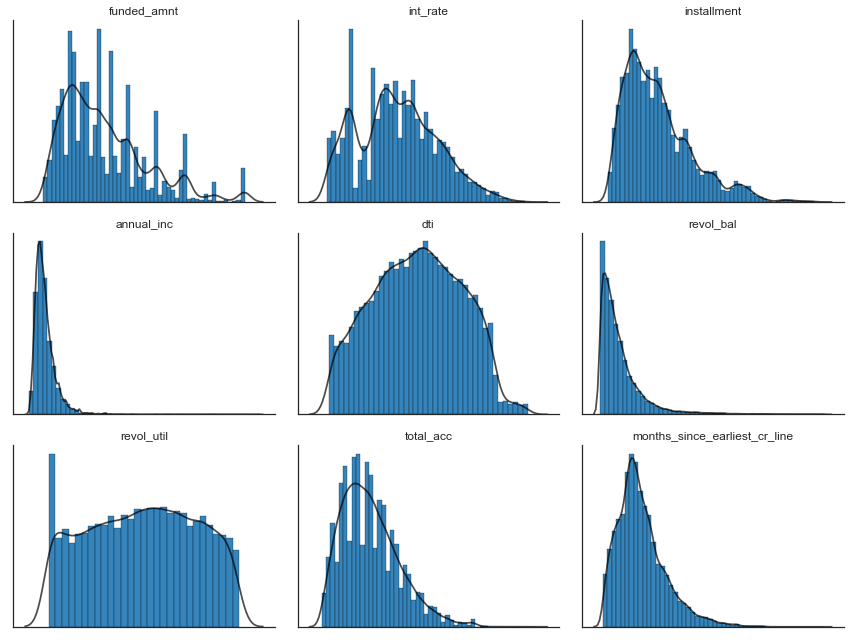

In [16]:
from statlearning import plot_histograms
plot_histograms(train[continuous])
plt.show()

The descriptive statistics further highlight these patterns. 

In [17]:
table = pd.DataFrame(train[continuous].skew().round(2), columns=['Skewness'])
table['Kurtosis'] = train[continuous].kurt().round(2)
table

,Skewness,Kurtosis
funded_amnt,1.09,0.95
int_rate,0.28,-0.49
installment,1.14,1.28
annual_inc,4.93,52.37
dti,-0.02,-0.83
revol_bal,3.25,15.23
revol_util,-0.05,-1.11
total_acc,0.83,0.68
months_since_earliest_cr_line,1.18,2.12


Next, we plot univariate logistic regressions of the response on the predictors. All the relationships are as expected, with the interest rate and loan-to-income ratio displaying the variables with the largest coefficients. 

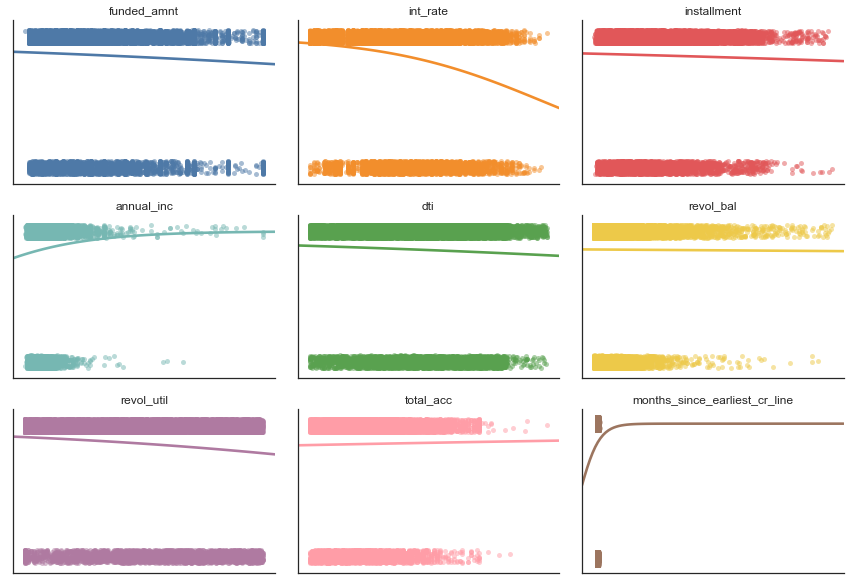

In [18]:
from statlearning import plot_logistic_regressions

with sns.color_palette(crayon):
    plot_logistic_regressions(train[continuous], y_train)
    plt.show()

The class-conditional distributions are mostly similar accross predictors. 

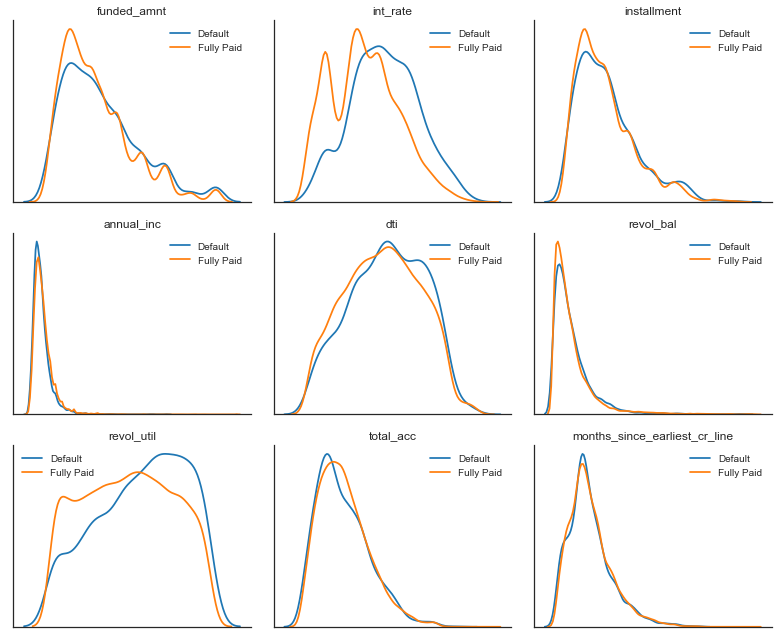

In [19]:
from statlearning import plot_conditional_distributions

plot_conditional_distributions(train[continuous], y_train, labels=['Default', 'Fully Paid'])
plt.show()

Next, we consider the purpose of the loan, which is only categorial variable that was not pre-processed. Loans for educational and small businesses purposes seem to be riskier than othre types of loans.  

In [20]:
train['purpose'].value_counts()

debt_consolidation    9183
credit_card           2460
other                 1953
home_improvement      1508
major_purchase        1051
small_business         899
car                    753
wedding                461
medical                353
moving                 264
vacation               201
house                  187
educational            152
renewable_energy        54
Name: purpose, dtype: int64

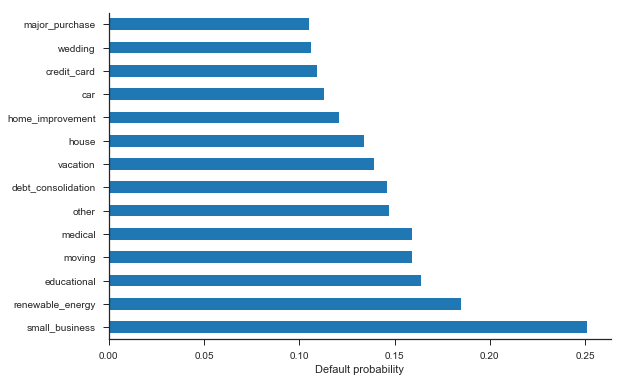

In [21]:
table = (1-train.groupby('purpose')['fully_paid'].mean()).sort_values(ascending=False).round(3)
fig, ax = plt.subplots()
table.plot(kind='barh', ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Default probability')
sns.despine()
plt.show()

## Data Preparation

Feature engineering is often the best way to improve the performance of a machine learning system. For example, domain knowledge may suggest that the size of the loan relative to income is important information.  

In [22]:
train['loan_to_income']=train['funded_amnt']/train['annual_inc']
test['loan_to_income']=test['funded_amnt']/test['annual_inc']
continuous.append('loan_to_income')

In the EDA section, we have seen that many numerical predictors are highly skewed, which can be detrimental to the performance of methods such as logistic regression. Log, Box-Cox, and power transformations are effective ways to reduce skewness. 

In [23]:
def log_transform(x, train, test):
    train[x] = np.log(train[x])
    test[x] = np.log(test[x])
    return train, test

from scipy.stats import boxcox
def box_cox_transform(x, train, test, shift=0.0):
    y, param  = boxcox(train[x]+shift)
    train[x] = y
    test[x] = boxcox(test[x]+shift, param)
    return train, test

train, test = log_transform('annual_inc', train, test)
train, test = log_transform('months_since_earliest_cr_line', train, test)
train, test = box_cox_transform('revol_bal', train, test, shift=1.0) # we add one to make the variable positive

As an additional step in data preparation, we need to code the remaining categorical variable using dummy variables. 

In [24]:
new_dummies = pd.get_dummies(data[['purpose']],  drop_first=True)
train=train.join(new_dummies.loc[index_train,:])
test=test.join(new_dummies.loc[index_test,:])

dummies+=list(new_dummies.columns)

Building the final design matrices: 

In [25]:
predictors = continuous + discrete + dummies

print('List of predictors: \n')
print(predictors)

scaler = StandardScaler()
X_train = scaler.fit_transform(train[predictors])
X_test = scaler.transform(test[predictors])

List of predictors: 

['funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'total_acc', 'months_since_earliest_cr_line', 'loan_to_income', 'emp_length', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'term_60', 'home_ownership_own', 'home_ownership_rent', 'verification_status_source verified', 'verification_status_verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding']


## Logistic Regression

The basic command to estimate a [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with Scikit-Learn is as follows. 

In [26]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

From the output, we notice that by default the method includes an $\ell^2$ penalty with an arbitrary penalty, which is not necessarily the behaviour that we would expect. The tuning parameter <TT>C</TT> is the inverse of the regularisation strength. 

In [27]:
logit = LogisticRegression(C=1e10)
logit.fit(X_train, y_train)

LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [28]:
from sklearn.linear_model import LogisticRegressionCV

logit_l1 = LogisticRegressionCV(Cs = 20, penalty='l1', solver='liblinear', scoring='neg_log_loss')
logit_l1.fit(X_train, y_train)

logit_l2 = LogisticRegressionCV(Cs = 20, penalty='l2', scoring='neg_log_loss')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=20, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

It can be helpful to plot the estimated coefficients.

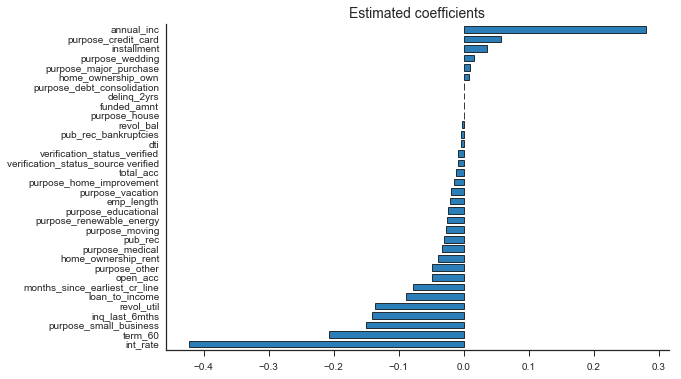

In [29]:
from statlearning import plot_coefficients

plot_coefficients(logit_l1, predictors)
plt.show()

All logistic regression specifications have very similar performance, so that we do not present a model selection exercise for conciseness.

## Model evaluation

We first compute the predicted probabilites and the corresponding decisions. We need to implement the decision function manually, which is simple to do.   

In [30]:
methods=[logit, logit_l1, logit_l2]

y_pred = np.zeros((len(y_test), len(methods)+1))
y_prob = np.zeros((len(y_test), len(methods)+1))

# Constant Probability Model (as an additional benchmark)
y_prob[:, 0] = np.mean(y_train) 
y_pred[:, 0]  = (y_prob[:,0]> tau).astype(int)

# Estimated Models
for i, method in enumerate(methods):
    y_prob[:,i+1] = method.predict_proba(X_test)[:,1]   
    y_pred[:,i+1]  = (y_prob[:,i+1]>tau).astype(int)

We evaluate the models in terms of their investment performance on the test set.  As a benchmark, we compare our models with a strategy of investing in all loans.  

In [31]:
columns=['Loans', 'Return on test set', 'Return given loan']

rows=['Invest in all', 'Constant probability', 'Logistic regression', 'L1 regularised', 'L2 regularised']

profitability = pd.DataFrame(0.0, columns=columns, index=rows)

for i in range(len(rows)):

    if i==0: 
        # invest in all 
        profitability.iloc[i,0] = 1.0
        profitability.iloc[i,1:3] = test['return'].mean()
        profitability.iloc[i,1:3] = test['return'].mean()
    else:
        profitability.iloc[i,0]= np.mean(y_pred[:,i-1])
        lp = y_pred[:,i-1]*test['return']
        ln = (1-y_pred[:,i-1])*(-loss_tn)  # the return from all the negatives is the same
        profitability.iloc[i,1]= np.mean(lp+ln)
        profitability.iloc[i,2] = np.sum(lp/np.sum(y_pred[:,i-1]))  
        
        expected = y_prob[:,i-1]*test['int_rate']+(1-y_prob[:,i-1])*(-loss_fp)

profitability.iloc[:,0]= profitability.iloc[:,0].round(3)
profitability.iloc[:,[1,2]]= (profitability.iloc[:,[1,2]]).round(2)    
profitability

,Loans,Return on test set,Return given loan
Invest in all,1.000,3.27,3.27
Constant probability,0.515,3.00,2.71
Logistic regression,0.631,4.74,5.58
L1 regularised,0.625,4.76,5.63
L2 regularised,0.626,4.74,5.58


As additional information, we can assess how discriminative our models are by comparing the average predicted probability for fully paid versus charged off loans.  

In [32]:
np.mean(y_prob[y_test==1, :], axis=0).round(4)

array([ 0.8596,  0.8702,  0.8693,  0.8699])

In [33]:
np.mean(y_prob[y_test==0, :], axis=0).round(4)

array([ 0.8596,  0.8042,  0.8047,  0.8056])

Next, we consider the traditional classification metrics, even though they are of secondary importance in this application. In order to make a more meaningful comparison, we give higher weights to defaults when computing the error rate, the area under the ROC curve, and the area under the precision-recall curve. 

Based on the specificity, the classification models avoid around 57% of defaults. 

In [34]:
columns=['Weighted error rate', 'Sensitivity', 'Specificity', 'Weighted AUC', 'Precision', 'Weighted AUPRC', 'Cross-entropy']

rows=['Constant probability', 'Logistic', 'L1 regularised', 'L2 regularised']

results=pd.DataFrame(0.0, columns=columns, index=rows)

weights=y_test+(1-y_test)*5
    
for i in range(len(rows)):
    confusion  = confusion_matrix(y_test,  y_pred[:,i]) 
    results.iloc[i,0]=  1 - accuracy_score(y_test, y_pred[:,i], sample_weight=weights)
    results.iloc[i,1]=  confusion[1,1]/np.sum(confusion[1,:])
    results.iloc[i,2]=  confusion[0,0]/np.sum(confusion[0,:])
    results.iloc[i,3]=  roc_auc_score(y_test, y_prob[:,i], sample_weight=weights)
    results.iloc[i,4]=  precision_score(y_test, y_pred[:,i])
    results.iloc[i,5]=  average_precision_score(y_test,  y_prob[:,i], sample_weight=weights)
    results.iloc[i,6]=  log_loss(y_test,  y_prob[:,i])

results.round(3)

,Weighted error rate,Sensitivity,Specificity,Weighted AUC,Precision,Weighted AUPRC,Cross-entropy
Constant probability,0.597,0.485,0.302,0.500,0.810,0.551,0.406
Logistic,0.380,0.663,0.568,0.698,0.904,0.735,0.375
L1 regularised,0.381,0.657,0.574,0.698,0.904,0.734,0.375
L2 regularised,0.382,0.658,0.569,0.698,0.903,0.735,0.375


The next cell plots the ROC curves.  

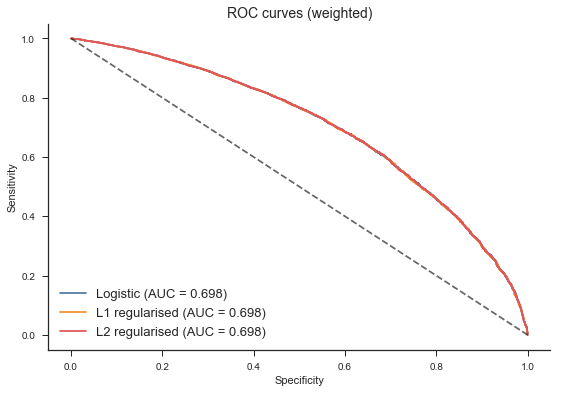

In [35]:
from statlearning import plot_roc_curves

with sns.color_palette(crayon):
    fig, ax = plot_roc_curves(y_test, y_prob[:,[1,2,3]], labels=pd.Series(rows).iloc[[1,2,3]], sample_weight=weights)
    ax.set_title('ROC curves (weighted)', fontsize=14)
    plt.show()

## Investment strategy

In the previous section, we considered the performance of our models across the entire test set. A better strategy for an individual investor participating in the peer-to-peer lending platform is to invest a portfolio of loans that have the highest expected return, with sufficient diversification to dilute the risk from defaults.

We implement this strategy for a portfolio size of 1000 loans, where we assume an equal investment in each loan.  The gradient boosting model achieves the best rate of return. 

In [36]:
columns=['Return', 'SE']

rows=['Constant', 'Logistic', 'L1 regularised', 'L2 regularised']

strategy  = pd.DataFrame(0.0, columns=columns, index=rows)

loans = 1000 # portfolio size

for i in range(len(rows)):
 
    expected = y_prob[:,i]*test['int_rate']+(1-y_prob[:,i])*(-loss_fp)
    expected   = expected.sort_values(ascending=False)
    strategy.iloc[i,0] = test.loc[expected.index[:loans],'return'].mean()
    strategy.iloc[i,1] = test.loc[expected.index[:loans],'return'].std()/np.sqrt(loans)

strategy.round(2)

,Return,SE
Constant,-0.51,1.22
Logistic,8.20,0.71
L1 regularised,8.14,0.72
L2 regularised,8.25,0.71


The rate of return depends on the portfolio size. Below, we plot the investment performance of different models as we vary the portfolio size. The tree-based methods perform best for smaller portfolio sizes, while the logistic GAM performs best for larger portfolios.  The linear stack is a compromise. 

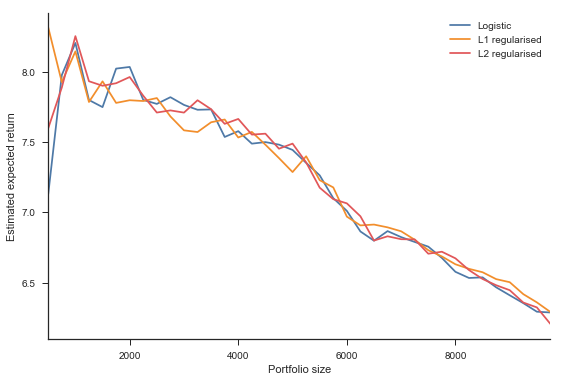

In [37]:
models = ['Constant', 'Logistic', 'L1 regularised', 'L2 regularised']

sizes = np.arange(500, 10000, 250)

returns = np.zeros((len(sizes), len(rows))) 

for i, loans in enumerate(sizes):
    for j in range(len(rows)):
        expected =   y_prob[:,j]*test['int_rate']+(1-y_prob[:,j])*(-loss_fp)
        expected  = expected.sort_values(ascending=False)
        returns[i,j] = test.loc[expected.index[:loans],'return'].mean()

returns = pd.DataFrame(returns, columns=models, index=sizes)

with sns.color_palette(crayon):
    fig, ax = plt.subplots()
    returns.iloc[:,1:].plot(ax=ax)
    ax.set_xlabel('Portfolio size')
    ax.set_ylabel('Estimated expected return')
    ax.set_title('')
    plt.legend()
    sns.despine()
    plt.show()